# Auto Encoder
        ↪ 입력을 latent space로 축소하는 encoder와 latent space로부터 복원하는 decoder로 구성된 네트워크

        ✔ 특징
            ▢ loss : reconstruction error (입력 데이터와 복원 데이터의 차이)
            ▢ 장점 : (1) 데이터 압축 (2) 입력 데이터의 핵심적인 특징을 추출
            ▢ 단점 : (1) 정보 손실
            ▢ 예시 : 이미지, 오디오 등의 미디어 파일 압축


#### Colab Link
    https://colab.research.google.com/drive/1Efk-KO6P5MINy6q7tVRCIJBM-xqTWK_h?usp=sharing

#### Reference
    https://colab.research.google.com/drive/13W6jA7N61NS-YPRn_jADIqBrMmIYart-?usp=sharing

In [ ]:
from tqdm import tqdm

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# train dataset
train_dataset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_dataloader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = 64,
    shuffle     = True,
    num_workers = 2
)

# test dataset
test_dataset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

print(f'train_dataset size : {len(train_dataset)} ')

train_dataset size : 60000 


In [ ]:
latent_dim = 3

class AutoEncoder(nn.Module) :
    def __init__(self, latent_dim) :
        super(AutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.latent_dim), # latent dimension으로 압축
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(), # 픽셀이 0과 1사이의 값을 출력하도록 sigmoid 사용
        )

    def forward(self, x) :
        en = self.encoder(x)
        de = self.decoder(en)
        return en, de

In [ ]:
def train(dataloader, autoencoder) :
    epoch_train_loss = 0

    for idx, (x, y) in enumerate(dataloader) :
        x = x.view(-1, 28*28).to(device)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss

    epoch_train_loss /= len(dataloader)
    return epoch_train_loss

Epoch : 5 train_loss : 0.024456


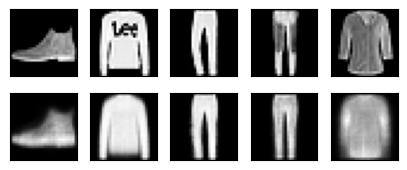


Epoch : 10 train_loss : 0.022465


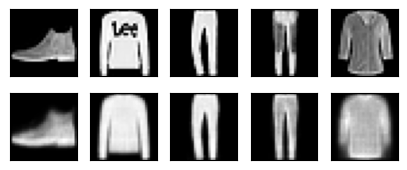


Epoch : 15 train_loss : 0.021700


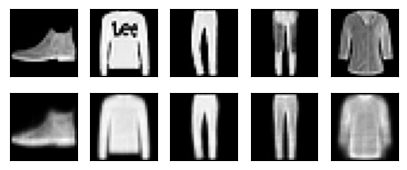


Epoch : 20 train_loss : 0.021243


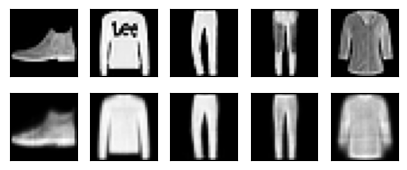

In [ ]:
epochs = 20
# 예시 이미지
view_data = test_dataset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255
train_loss_list = []

autoencoder = AutoEncoder(latent_dim).to(device)
# Reconstruction Error : input과 output의 차이를 계산 하기 위해 평균제곱오차(Mean Squared Loss) 사용
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(1,epochs+1) :
    train_loss = train(train_dataloader, autoencoder)
    train_loss_list.append(train_loss)

    if epoch % 5 == 0 :
        print(f'Epoch : {epoch} train_loss : {train_loss:.6f}')
        _, decoded = autoencoder(view_data.to(device))

        f, a = plt.subplots(2, 5, figsize=(5, 2))
        for i in range(5) :
            img = view_data[i].view(28, 28).numpy()
            a[0][i].imshow(img, cmap='gray')
            a[0][i].set_xticks(())
            a[0][i].set_yticks(())

        for i in range(5) :
            img = np.reshape(decoded.data.to('cpu').numpy()[i], (28, 28))
            a[1][i].imshow(img, cmap='gray')
            a[1][i].set_xticks(())
            a[1][i].set_yticks(())
        plt.show()
        print()